# Exploring the Relationship Between Player Age and Playtime for Targeted Newsletter Campaigns
Names: Danial Zahid,  Peter Wang

Date: December 6th, 2025

## Introduction

Understanding player engagement on game servers is crucial for successful communication strategies, such as newsletter campaigns. Players choose to subscribe to a newsletter for updates, research information, and community links. Discovering which player profiles subscribe will aid researchers in more effectively reaching and retaining committed participants.

This project explores whether player characteristics, specifically **player age** and **time spent playing**, can be used to predict if a player will subscribe to the game newsletter. By analyzing this relationship, we can identify which age groups are most engaged with the game and could be the most responsive to future newsletter campaigns.,

The data was collected from a Minecraft research server managed by the UBC PLAI group (https://plaicraft.ai), which collects information about players.

Demographics and statistics: This analysis will focus on the **players.csv dataset**, which contains demographic information such as players' age, subscription status, and the amount of time played. Once the data has been cleaned, wrangled, and prepared, we will apply the k-nearest neighbours (KNN) classification model to examine whether age and playtime predict newsletter subscription.

**Question of Interest:** Is there a relationship between the age of players and the time they spend playing that could inform which group of players to target for newsletter subscription campaigns?

Response Variable: 'subscribe'

Explanatory Variable: 'Age', 'played_hours'

## Methods and Results

First, we loaded the **players.csv** dataset and selected the variables needed for the classification model. Some players had missing values for 'age' and 'played_hours', so these were removed. Additionally, we have decided to convert the 'subscribe' indicator to a categorical variable.

In [56]:
# Load the libraries
library(tidyverse)
library(ggplot2)
library(repr)
library(scales)
library(tidymodels)

In [57]:
# Load the dataset
# Make "subscribe" a factor for cross-validation later.
players <- read_csv("players.csv") |>
    mutate(subscribe = factor(subscribe)) |>
    drop_na()

head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [22]:
# Find the number of rows and columns
cat("Number of observations:", nrow(players), "\n")
cat("Number of variables:", ncol(players), "\n")

Number of observations: 194 
Number of variables: 7 


In [23]:
# Show the variable names of the dataset
colnames(players)

[1] "experience"   "subscribe"    "hashedEmail"  "played_hours" "name"        
[6] "gender"       "Age"

From the information generated above from loading the data, we can see that "players" contains data on 196 different users. 
We have information regarding each player's:
- Minecraft experience
- Newsletter subscription status
- Email ID
- Time spent playing on the server (in hours)
- Name
- Gender
- Age

Our investigation will focus on the "subscribe", "Age", and "played_hours" variables. 

Upon inspecting the data and identifying the variables of value to us, we must address a few potential issues we see within the dataset.
1. The data appears to be skewed towards players who put in their information but may not have at all intended to produce data for the research.
2. There may not be enough data from certain age ranges to generalize findings in this analysis to greater populations.

We will address the first issue by removing all observations with 0 hours played, since they are a unique group that does not provide insight into our investigation. The decision to participate in the study without contributing any time is a pattern that transcends any variable, including age. This isn't a perfect solution, but it will remove pointless observations and help us avoid a regression analysis that is influenced by them.

Our utilization of k-nearest neighbors classification will address the second issue. Even though the method is based on stronger inter-variable correlation in some datasets than others, we can do our best to eliminate confounding factors and coincidence by splitting our dataset into groups used for training and testing, respectively. How much or little the results of this analysis should be valued is ultimately at the discretion of the UBC Computer Science researchers.

We will be using this filtered dataframe from now on, since it excludes observations that are not useful to us. Now we will collect some statistics that will contribute to our understanding of the sample we've been given. We will find the mean and standard deviation of the age of all participants and the time each of them spent on the server.

In [41]:
players_statistics <- players |>
summarize(mean_age = mean(Age, na.rm = TRUE), sd_age = sd(Age, na.rm = TRUE), mean_hours = mean(played_hours), sd_hours = sd(played_hours))
players_statistics

mean_age,sd_age,mean_hours,sd_hours
<dbl>,<dbl>,<dbl>,<dbl>
21.13918,7.389687,5.904639,28.49793


We'll now take a first look at the categorical variable we'll be looking at – the subscription status of each player.

In [42]:
subscribe_count <- players |>
count(subscribe)
subscribe_count

subscribe,n
<fct>,<int>
FALSE,52
TRUE,142


Out of the 111 players who actually spent time on the server, 86 were subscribed, while 25 were not. 

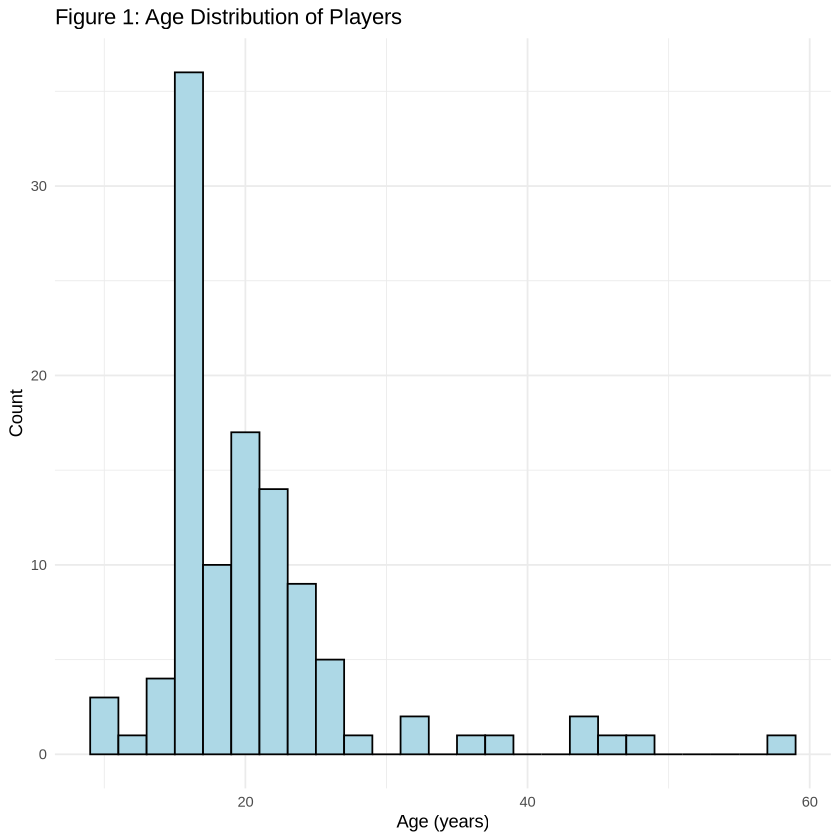

In [60]:
figure1 <- ggplot(players_filtered, aes(x = Age)) +
  geom_histogram(binwidth = 2, fill = "lightblue", color = "black") +
  labs(title = "Figure 1: Age Distribution of Players",
       x = "Age (years)", y = "Count") +
  theme_minimal()
figure1

The histogram shows that the largest majority of players who have subscribed to a game newsletter are between 10 and 30 years old, with a high concentration of players who are around ages 15-20. There are very few players who are older than 40. This indicates that most current subscriptions are from younger players and shows that they are likely the most appropriate group for newsletter-targeting campaigns. Furthermore, the number of players who have subscribed to the newsletter is more than double the number who have not subscribed.

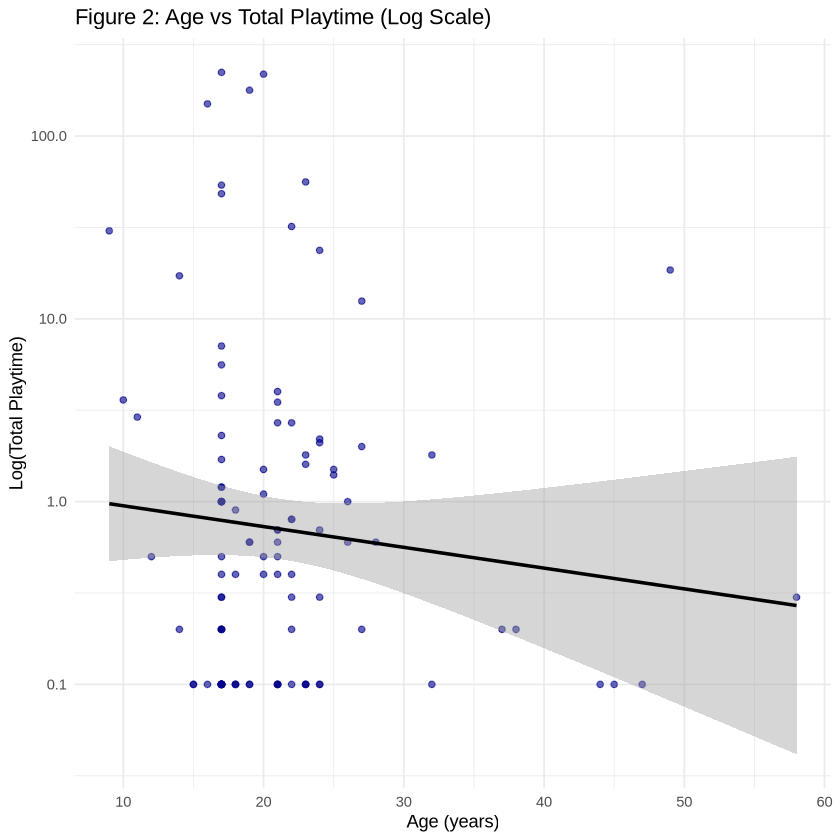

In [66]:
figure2 <- ggplot(players_filtered, aes(x = Age, y = played_hours)) +
  geom_point(alpha = 0.6, color = "darkblue") +
  scale_y_log10() +
  geom_smooth(method = "lm", color = "black", se = TRUE, formula = y ~ x) +
  labs(title = "Figure 2: Age vs Total Playtime (Log Scale)",
    x = "Age (years)", y = "Log(Total Playtime)") +
  theme_minimal()
figure2

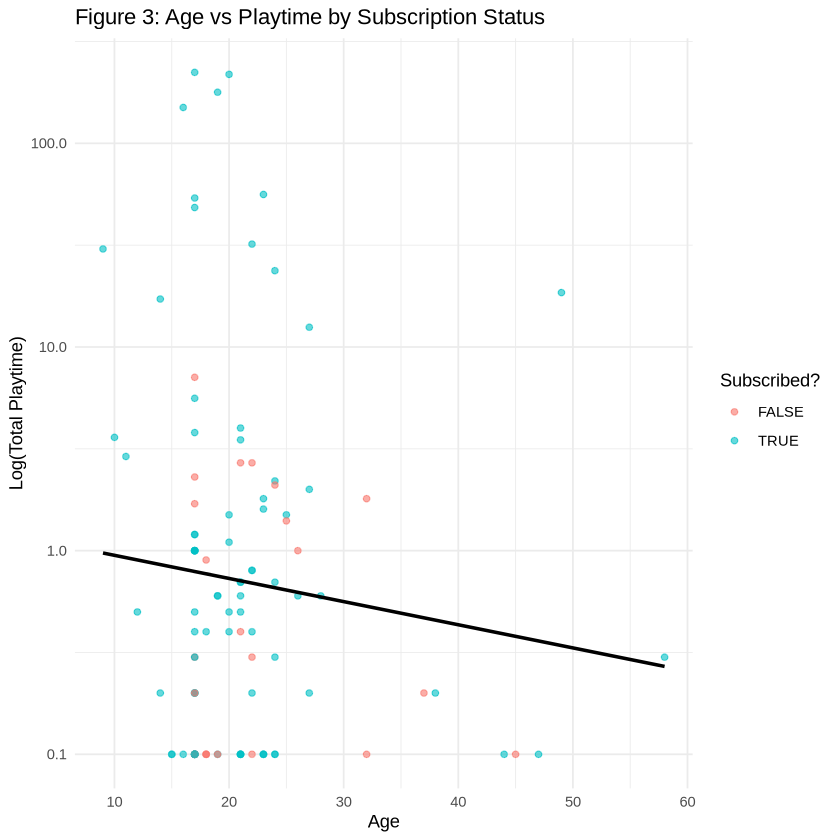

In [65]:
figure3 <- ggplot(players_filtered, aes(x = Age, y = played_hours, color = subscribe)) +
  geom_point(alpha = 0.6) +
  scale_y_log10() +
  geom_smooth(method = "lm", se = FALSE, color = "black", formula = y ~ x) +
  labs(title = "Figure 3: Age vs Playtime by Subscription Status",
       x = "Age", y = "Log(Total Playtime)", color = "Subscribed?") +
  theme_minimal()
figure3

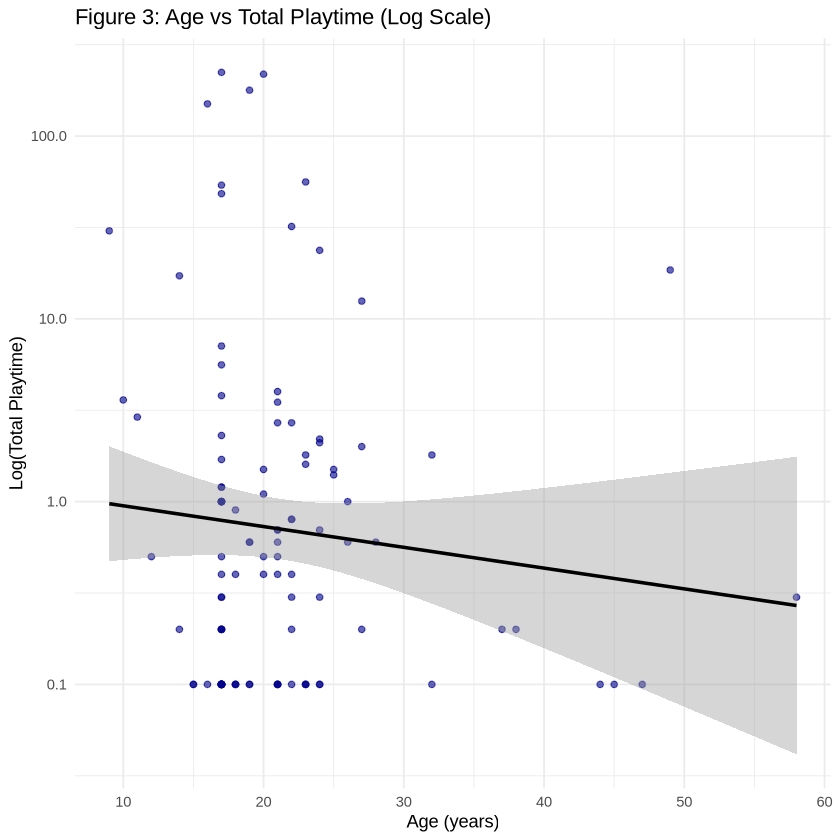

In [64]:
figure4 <- ggplot(players_filtered, aes(x = Age, y = played_hours)) +
  geom_point(alpha = 0.6, color = "darkblue") +
  scale_y_log10() +
  geom_smooth(method = "lm", color = "black", se = TRUE, formula = y ~ x) +
  labs(
    title = "Figure 3: Age vs Total Playtime (Log Scale)",
    x = "Age (years)",
    y = "Log(Total Playtime)"
  ) +
  theme_minimal()

figure4

The scatterplots show that most players have relatively low playtime hours, but there are a few players who have higher hours, with outliers spending 150 or more hours. The trend shows a weak or slightly negative linear relationship, meaning that as 'Age' increases, the 'played_hours' tends to decrease. This suggests that younger players are more active in the game compared to older players.

## Methods

Now we will build a K-NN classification model for this dataset step by step. Our goal is to classify players as subscribers or non-subscribers based on their age and the number of hours they spend on the server.

The first step is to split the data into a training set and a testing set. The training set is used to build the model, and the testing set is used to evaluate how well the model performs on new data. We allocate 75 percent of the original dataset to the training set and the remaining 25 percent to the testing set.

In [36]:
set.seed(1) # This makes the results reproducible
players_split <- initial_split(players, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

Another important step is to standardize the original data. Age and played_hours measure different things and span very different ranges, so they would not contribute equally to the K-NN model if left unscaled. Age has a narrow natural range, while played_hours can reach several hundred. Standardizing these predictors ensures that each variable contributes on a comparable scale.

We standardize the training data as part of the recipe that will be passed into the model.

In [37]:
players_recipe <- recipe(subscribe ~ Age + played_hours, data = players_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

Before we move on to the next step in training the model, we must figure out what $K$ value to use. The $K$ value will decide the number of neighboring observations that will be used to classify a new observation. Through a cross-validation process in which we test out many possible $K$ values, we can find the one that provides the most accurate classification. 

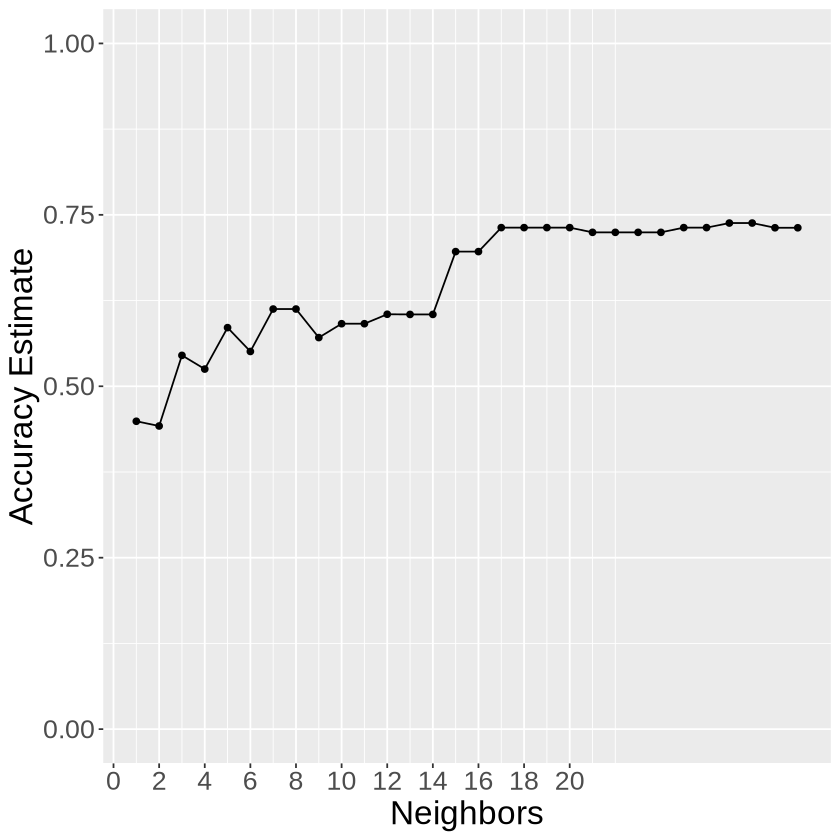

In [38]:
set.seed(1)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 30, by = 1))

knn_results <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = players_vfold, grid = k_vals) |> 
  collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")

cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") +
  theme(text = element_text(size = 20)) +
  scale_x_continuous(breaks = seq(0, 20, 2)) +
  scale_y_continuous(limits = c(0, 1))

cross_val_plot

As shown in the graph above, the accuracy of the model stops increasing at a meaningful rate after \(K = 17\). Therefore, 17 is the most appropriate \(K\) value for our model. We can now continue building the model.

We will create the classifier by specifying that we want \(K = 17\) neighbors and that the distance metric should be the straight-line (Euclidean) distance.

In [58]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 17) |>
  set_engine("kknn") |>
  set_mode("classification")

Now we will combine the model specification and the training data set to train the classifier. 

In [59]:
players_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(knn_spec) |>
  fit(data = players_train)

Our classifier is now complete. We will test its competence here with the testing dataset. We will then add a column of predictions made by the classifier to the original testing dataset.

In [50]:
players_test_predictions <- predict(players_fit, players_test) |>
  bind_cols(players_test)

Now we will calculate the classifier's accuracy using the predictions it generated. This step compares the predicted subscription status to the actual subscription status in the testing dataset.

In [52]:
players_prediction_accuracy <- players_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class)

players_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.73469388
kap,binary,0.06734993


Our model achieved an accuracy of approximately 71.43 percent. The low kappa value indicates that this accuracy is likely inflated due to factors such as the unequal proportions of subscribers and non-subscribers in the dataset.

Next, we will produce a confusion matrix to gain deeper insight into the model's performance.

In [54]:
players_mat <- players_test_predictions |>
  conf_mat(truth = subscribe, estimate = .pred_class)

players_mat

          Truth
Prediction FALSE TRUE
     FALSE     1    1
     TRUE     12   35

This confusion matrix shows the following for the 49 predictions made on the testing dataset:

- 1 non-subscriber was correctly classified as a non-subscriber.
- 34 subscribers were correctly classified as subscribers.
- 12 non-subscribers were incorrectly classified as subscribers.
- 2 subscribers were incorrectly classified as non-subscribers.

These results explain the low kappa value observed earlier. The model tended to classify players as subscribers because the training dataset contained far more subscribers than non-subscribers.

We will treat `TRUE` (subscribed) as the positive class and `FALSE` (not subscribed) as the negative class.

The precision of the model is \(\frac{34}{34 + 12}\), meaning the model is correct about 74 percent of the time when it predicts “subscriber.”

The recall of the model is \(\frac{34}{34 + 2}\), meaning it correctly identifies about 94 percent of true subscribers, while the remaining subscribers are incorrectly classified as non-subscribers.

We can also interpret the confusion matrix in terms of errors. Type I errors occur when non-subscribers are classified as subscribers, and Type II errors occur when subscribers are classified as non-subscribers.

The confusion matrix shows that the model made 12 Type I errors and 2 Type II errors.

About \(\frac{12}{12 + 1} \approx 92\%\) of non-subscribers were incorrectly labeled as subscribers. Only \(\frac{2}{2 + 34} \approx 6\%\) of subscribers were incorrectly labeled as non-subscribers.

This reinforces that the model heavily favors predicting the subscriber class. It is effective at identifying subscribers but performs poorly at identifying non-subscribers.

## Discussion

-

## GitHub Repository Link

-